In [1]:
import numpy as np, pandas as pd
from glob import glob
from astropy.table import Table
from matplotlib import pyplot as plt, colors as colors, colorbar as cbar
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from WISE_tools import *

%matplotlib inline

In [2]:
good = pd.read_csv('../data/bright_sample/massive.csv.gz')
len(good)

6484

In [3]:
lightcurve_directory = '../data/WISE_lcs/'
source_names = parse_source_names(lightcurve_directory)
print(source_names[0],len(source_names))

J000041.86+554320.8 6484


/Volumes/shoobert/Research/UW/GaiaSprintMassive/WISE/code/WISE_tools.py:81: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  df = pd.concat(dfs)


<ErrorbarContainer object of 3 artists>

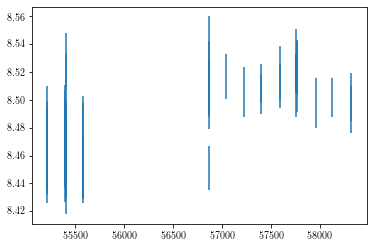

In [4]:
lc = get_lightcurve(source_names[0],lightcurve_directory)
plt.errorbar(lc['mjd'],lc['w1mpro'],lc['w1sigmpro'],ls='')
#print(lc['cc_flags'].astype(object).astype(str).str[0:2])
#(lc['cc_flags'].astype(object).astype(str).str[0:2] == '00') | (lc['cc_flags'].astype(object).astype(str).str[0:2] == '0')

In [5]:
def mean_per_visit(time,mag,err,dt_tol=100):
    """
    Calculates the mean per-visit point.
    
    Assume some delta time over which something is considered a separate visit.
    """
    visits = []
    visit = np.array([[time[0],mag[0],err[0]]])
    for i in range(1,len(time)):
        dif = time[i] - time[i-1]
        if dif <= dt_tol:
            visit = np.append(visit,[[time[i],mag[i],err[i]]],axis=0)
        else:
            visits.append(visit)
            visit = np.array([[time[i],mag[i],err[i]]])
    visits.append(visit)
    visits = np.array(visits)
    mean_times = []
    mean_mags = []
    mean_errs = []
    for visit in visits:
        mean_times.append(np.mean(visit[:,0]))
        mean_mags.append(np.mean(visit[:,1]))
        mean_errs.append(np.sqrt(np.sum(np.power(visit[:,2],2.0)))/len(visit))
    return np.array(mean_times),np.array(mean_mags),np.array(mean_errs)


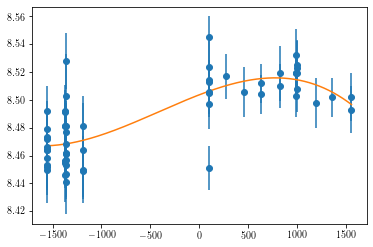

In [6]:
from scipy import interpolate
t, m, e = lc['mjd'].values, lc['w1mpro'].values, lc['w1sigmpro'].values
t_sub = t - 0.5*(t[0] + t[-1])
mt,mm,me = mean_per_visit(t_sub,m,e)
tck = interpolate.splrep(mt, mm, w=1.0/me, s=10)
ts = np.linspace(t_sub[0],t_sub[-1],1000)
mfit = interpolate.splev(ts, tck, der=0)
plt.errorbar(t_sub,m,e,ls='',fmt='o')
plt.plot(ts,mfit)

/Users/carina/anaconda/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/carina/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/carina/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/carina/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/carina/anaconda/lib/python3.6/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


nan nan


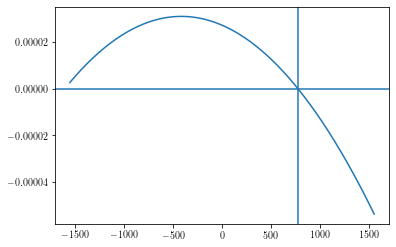

In [7]:
mfit_der = interpolate.splev(ts, tck, der=1)
plt.plot(ts,mfit_der)
mfit_zeros = []
for i, d in enumerate(mfit_der[:-1]):
    if np.sign(d) != np.sign(mfit_der[i+1]):
        test_times = np.linspace(ts[i],ts[i+1],100)
        test_mfit = interpolate.splev(test_times,tck,der=1)
        mfit_zeros.append(test_times[np.argmin(test_mfit)])

for z in mfit_zeros:
    plt.axvline(z)
plt.axhline(0)
zeros_diff = np.diff(mfit_zeros)
print(np.mean(zeros_diff),np.std(zeros_diff))

```python
N_visits = []
w1_nzero = []
w1_mean_dt = []
w1_std_dt = []
w2_nzero = []
w2_mean_dt = []
w2_std_dt = []
color_nzero = []
color_mean_dt = []
color_std_dt = []
current_RA = '00'
print(current_RA)
for i,name in enumerate(source_names):
    lc = get_lightcurve(name,lightcurve_directory)
    if name[1:3] != current_RA:
        current_RA = name[1:3]
        print(current_RA)
    t, w1, w1e, w2, w2e, w12, w12e = [lc['mjd'].values, lc['w1mpro'].values, 
                                      lc['w1sigmpro'].values, lc['w2mpro'].values, 
                                      lc['w2sigmpro'].values, lc['w1w2'].values, 
                                      lc['w1w2err'].values]
    if len(t) == 0:
        N_visits.append(0)
        w1_nzero.append(0)
        w1_mean_dt.append(0)
        w1_std_dt.append(0)
        w2_nzero.append(0)
        w2_mean_dt.append(0)
        w2_std_dt.append(0)
        color_nzero.append(0)
        color_mean_dt.append(0)
        color_std_dt.append(0)
        continue
        
    t_sub = t - 0.5*(t[0] + t[-1]) #so that lc is centered on zero

    ts = np.linspace(t_sub[0],t_sub[-1],1000)

    mt, mw1m, mw1e = mean_per_visit(t_sub, w1, w1e)
    _, mw2m, mw2e = mean_per_visit(t_sub, w2, w2e)
    _, mw12m, mw12e = mean_per_visit(t_sub, w12, w12e)
    N_visit = len(mt)
    if N_visit <= 3:
        N_visits.append(N_visit)
        w1_nzero.append(0)
        w1_mean_dt.append(0)
        w1_std_dt.append(0)
        w2_nzero.append(0)
        w2_mean_dt.append(0)
        w2_std_dt.append(0)
        color_nzero.append(0)
        color_mean_dt.append(0)
        color_std_dt.append(0)
        continue
    
    tck_w1 = interpolate.splrep(mt, mw1m, w=1.0/mw1e, s=10)
    tck_w2 = interpolate.splrep(mt, mw2m, w=1.0/mw2e, s=10)
    tck_w12 = interpolate.splrep(mt, mw12m, w=1.0/mw12e, s=10)

    splder_w1 = interpolate.splev(ts, tck_w1, der=1)
    splder_w2 = interpolate.splev(ts, tck_w2, der=1)
    splder_w12 = interpolate.splev(ts, tck_w12, der=1)

    derzero_w1 = []
    derzero_w2 = []
    derzero_w12 = []

    for i, [d1, d2, d12] in enumerate(zip(splder_w1[:-1],splder_w2[:-1],splder_w12[:-1])):
        if np.sign(d1) != np.sign(splder_w1[i+1]):
            test_times = np.linspace(ts[i],ts[i+1],100)
            test_mfit = interpolate.splev(test_times,tck_w1,der=1)
            derzero_w1.append(test_times[np.argmin(test_mfit)])
        if np.sign(d2) != np.sign(splder_w2[i+1]):
            test_times = np.linspace(ts[i],ts[i+1],100)
            test_mfit = interpolate.splev(test_times,tck_w2,der=1)
            derzero_w2.append(test_times[np.argmin(test_mfit)])
        if np.sign(d12) != np.sign(splder_w12[i+1]):
            test_times = np.linspace(ts[i],ts[i+1],100)
            test_mfit = interpolate.splev(test_times,tck_w12,der=1)
            derzero_w12.append(test_times[np.argmin(test_mfit)])

    w1_diff = np.diff(derzero_w1)
    w2_diff = np.diff(derzero_w2)
    w12_diff = np.diff(derzero_w12)

    Nzero_w1 = len(w1_diff)
    Nzero_w2 = len(w2_diff)
    Nzero_w12 = len(w12_diff)

    mean_dt_w1, std_dt_w1 = np.mean(w1_diff), np.std(w1_diff)
    mean_dt_w2, std_dt_w2 = np.mean(w2_diff), np.std(w2_diff) 
    mean_dt_w12, std_dt_w12 = np.mean(w12_diff), np.std(w12_diff) 

    N_visits.append(N_visit)
    w1_nzero.append(Nzero_w1)
    w1_mean_dt.append(mean_dt_w1)
    w1_std_dt.append(std_dt_w1)
    w2_nzero.append(Nzero_w2)
    w2_mean_dt.append(mean_dt_w2)
    w2_std_dt.append(std_dt_w2)
    color_nzero.append(Nzero_w12)
    color_mean_dt.append(mean_dt_w12)
    color_std_dt.append(std_dt_w12)
                                      
    if i%100 == 0:
        print(i)
        
timescale_df = pd.DataFrame({'WISE_Designation':source_names,'N_visits':N_visits,
                             'W1_Nzeroes':w1_nzero,'W1_meanDt':w1_mean_dt,'W1_stdDt':w1_std_dt,
                             'W2_Nzeroes':w2_nzero,'W2_meanDt':w2_mean_dt,'W2_stdDt':w2_std_dt,
                             'W1-W2_Nzeroes':color_nzero,'W1-W2_meanDt':color_mean_dt,
                             'W1-W2_stdDt':color_std_dt})
timescale_df.to_csv('timescales.csv')

```

In [8]:
timescale_df = pd.read_csv('timescales.csv')

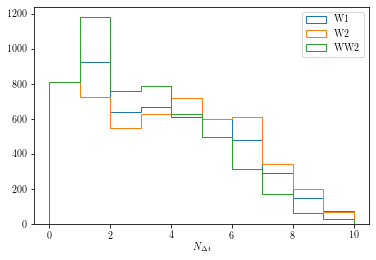

In [9]:
plt.hist(timescale_df.dropna()['W1_Nzeroes'],histtype='step',label='W1')
plt.hist(timescale_df.dropna()['W2_Nzeroes'],histtype='step',label='W2')
plt.hist(timescale_df.dropna()['W1-W2_Nzeroes'],histtype='step',label='WW2')
plt.xlabel(r'$N_{\Delta t}$')
plt.legend()

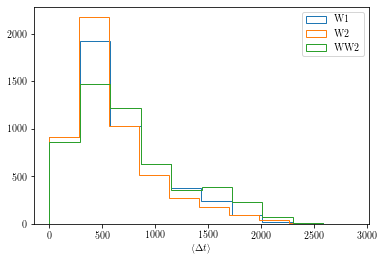

In [10]:
plt.hist(timescale_df.dropna()['W1_meanDt'],histtype='step',label='W1')
plt.hist(timescale_df.dropna()['W2_meanDt'],histtype='step',label='W2')
plt.hist(timescale_df.dropna()['W1-W2_meanDt'],histtype='step',label='WW2')
plt.xlabel(r'$\langle \Delta t \rangle$')
plt.legend()

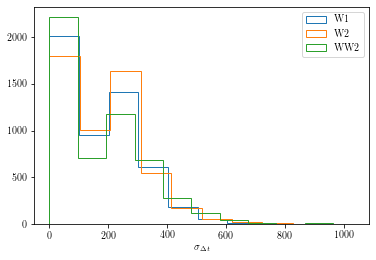

In [11]:
plt.hist(timescale_df.dropna()['W1_stdDt'],histtype='step',label='W1')
plt.hist(timescale_df.dropna()['W2_stdDt'],histtype='step',label='W2')
plt.hist(timescale_df.dropna()['W1-W2_stdDt'],histtype='step',label='WW2')
plt.xlabel(r'$\sigma_{\Delta t}$')
plt.legend()

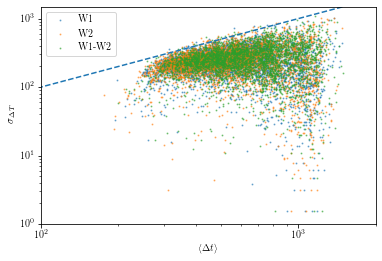

In [12]:
plt.plot([0,2000],[0,2000],ls='--')
plt.scatter(timescale_df['W1_meanDt'],timescale_df['W1_stdDt'],s=1,label='W1',alpha=0.5)
plt.scatter(timescale_df['W2_meanDt'],timescale_df['W2_stdDt'],s=1,label='W2',alpha=0.5)
plt.scatter(timescale_df['W1-W2_meanDt'],timescale_df['W1-W2_stdDt'],s=1,label='W1-W2',alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim(1e2,2000)
plt.ylim(1e0,1500)
plt.xlabel(r'$\langle \Delta t \rangle$')
plt.ylabel(r'$\sigma_{\Delta T}$')
plt.legend()

In [13]:
def cdf(array, norm=True):
    """
    Calculates the cumulative density function of a given array. Default behavior is to
    normalize the CDF for easy comparison between arrays of different sizes
    
    Parameters
    ----------
    array : array-like
        Array to calculate CDF of
        
    norm : bool
        Whether to normalize by the size of array. Default True.
    
    Returns
    -------
    vals : array-like
        Abcissa of density
    density : array-like
        Values of CDF
    
    """
    
    vals = np.sort(array[~np.isnan(array)])
    
    density = np.array([i+1 for i in range(len(vals))])
    
    if norm:
        density = density/len(vals)
        
    mean_dif = np.mean(np.diff(vals))
    
    vals = np.insert(vals, 0, np.min([0,vals[0]-mean_dif]))
    density = np.insert(density, 0, 0)
        
    return vals, density

In [14]:
classification_df = pd.read_csv('classifications.csv')
joined = good.merge(classification_df,on='source_id')
joined = joined.merge(timescale_df,left_on='designation',right_on='WISE_Designation')
joined.columns

Index(['BP-RP', 'Galaxy', 'M_G', 'M_W1', 'W1-W2', 'W2-W3', 'W3-W4', 'a_g_val',
       'allwise_oid', 'dec', 'designation', 'original_ext_source_id',
       'parallax', 'parallax_error', 'phot_bp_mean_mag', 'phot_g_mean_mag',
       'phot_rp_mean_mag', 'r_est', 'r_hi', 'r_len', 'r_lo', 'ra', 'source_id',
       'w1mpro', 'w1mpro_error', 'w2mpro', 'w2mpro_error', 'w3mpro',
       'w3mpro_error', 'w4mpro', 'w4mpro_error', 'CommonName_x', 'MKType',
       'SimbadOType', 'SpT', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag',
       'e_Kmag', 'G-J', 'J-H', 'H-K', 'K-W1', 'J-W1', 'Unnamed: 0_x',
       'CommonName_y', 'Class', 'CoarseClass', 'IsBinary', 'Unnamed: 0_y',
       'WISE_Designation', 'N_visits', 'W1_Nzeroes', 'W1_meanDt', 'W1_stdDt',
       'W2_Nzeroes', 'W2_meanDt', 'W2_stdDt', 'W1-W2_Nzeroes', 'W1-W2_meanDt',
       'W1-W2_stdDt'],
      dtype='object')

Text(0, 0.5, 'CDF')

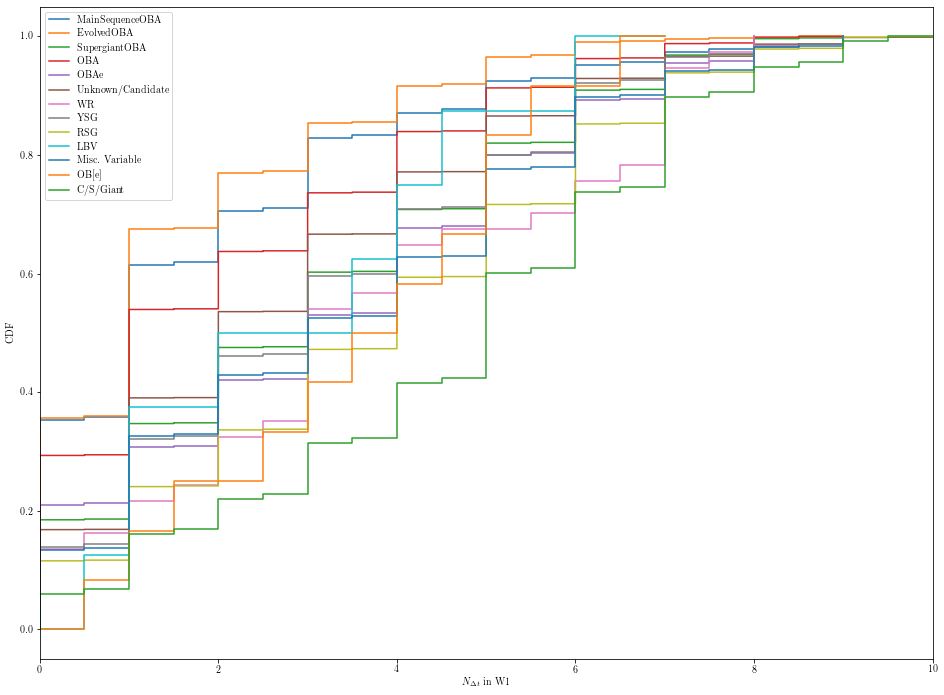

In [15]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1_Nzeroes'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlim(0,10)
plt.xlabel('$N_{\Delta t}$ in W1')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

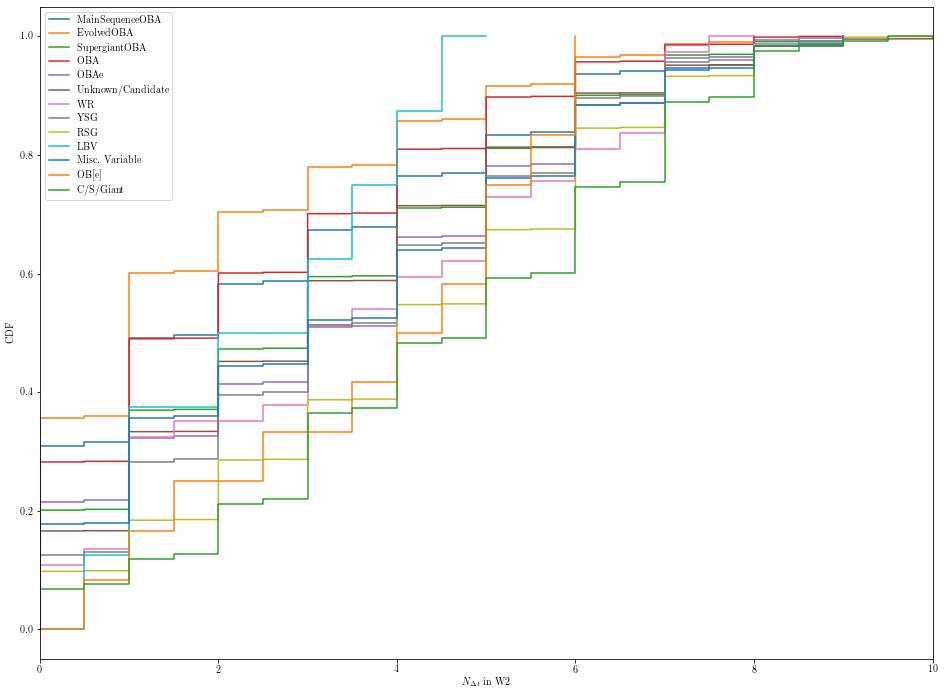

In [17]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W2_Nzeroes'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlim(0,10)
plt.xlabel('$N_{\Delta t}$ in W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

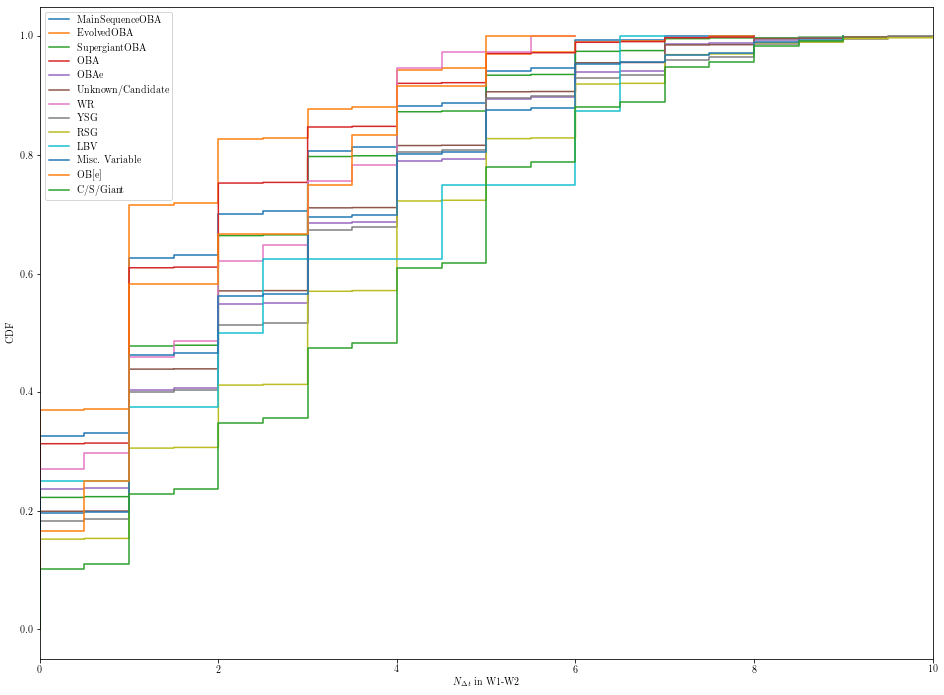

In [18]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1-W2_Nzeroes'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlim(0,10)
plt.xlabel('$N_{\Delta t}$ in W1-W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

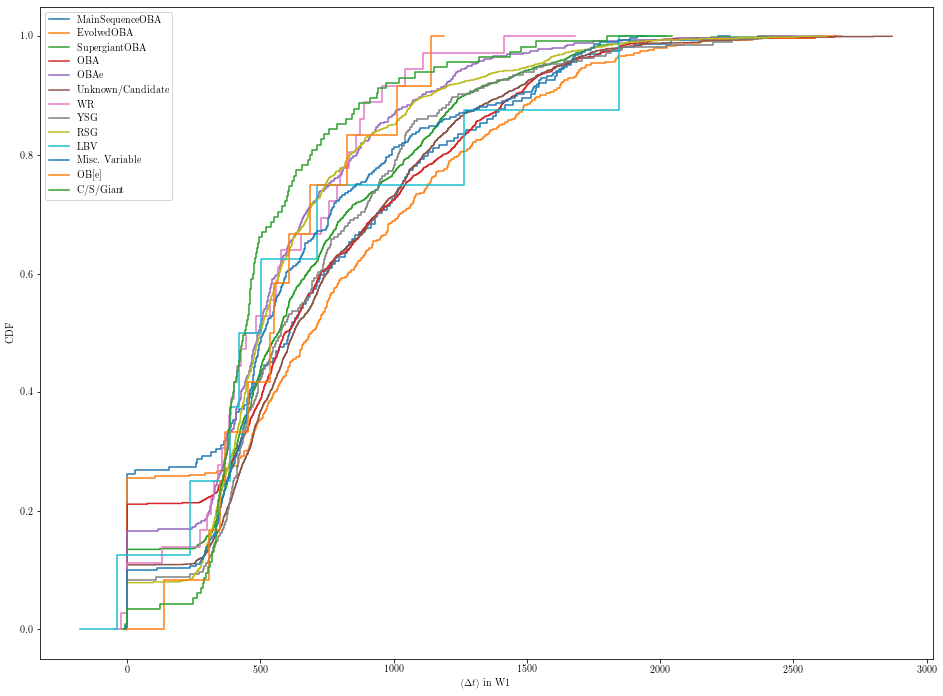

In [23]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1_meanDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlabel(r'$\langle{\Delta t}\rangle$ in W1')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

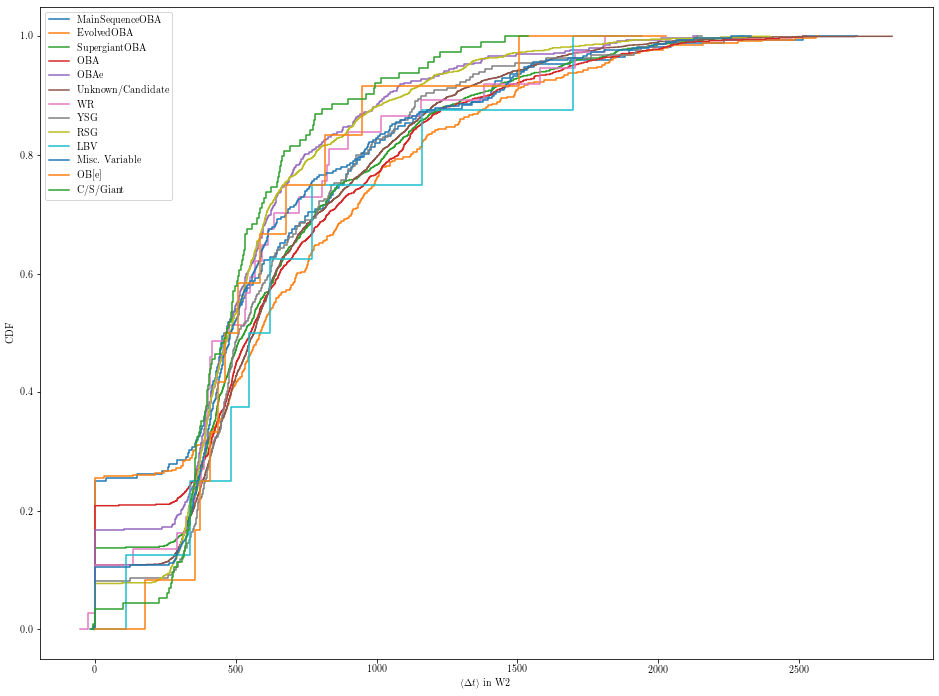

In [22]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W2_meanDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlabel(r'$\langle{\Delta t}\rangle$ in W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

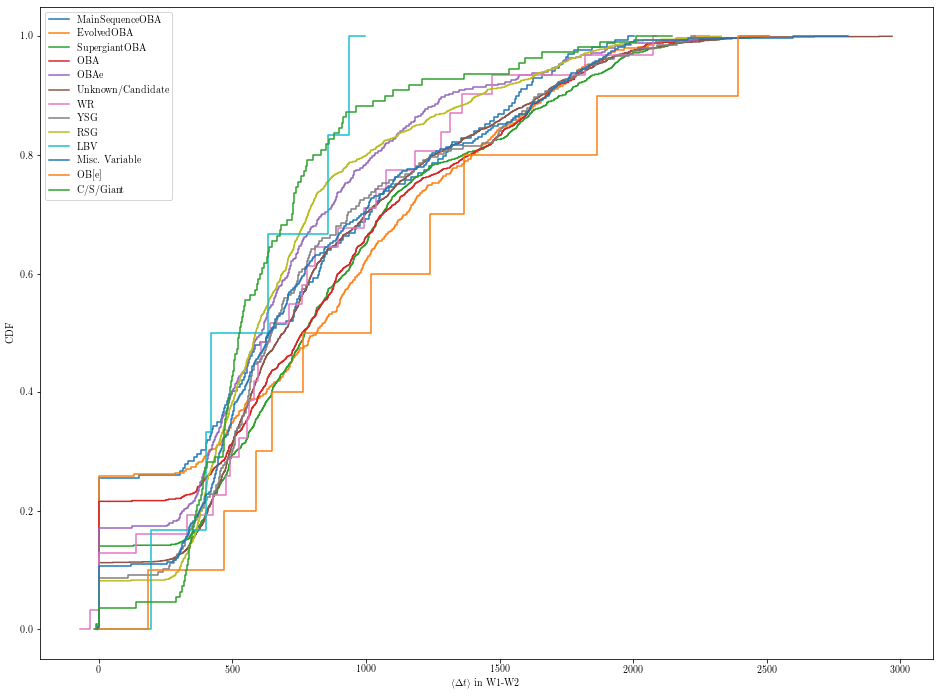

In [24]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1-W2_meanDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlabel(r'$\langle{\Delta t}\rangle$ in W1-W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

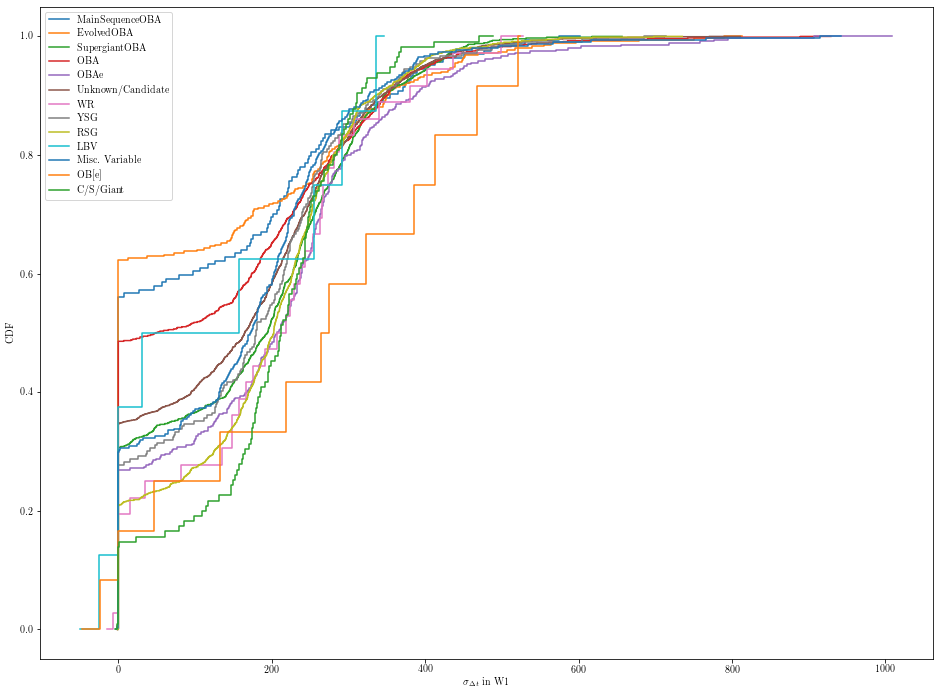

In [25]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1_stdDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlabel(r'$\sigma_{\Delta t}$ in W1')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

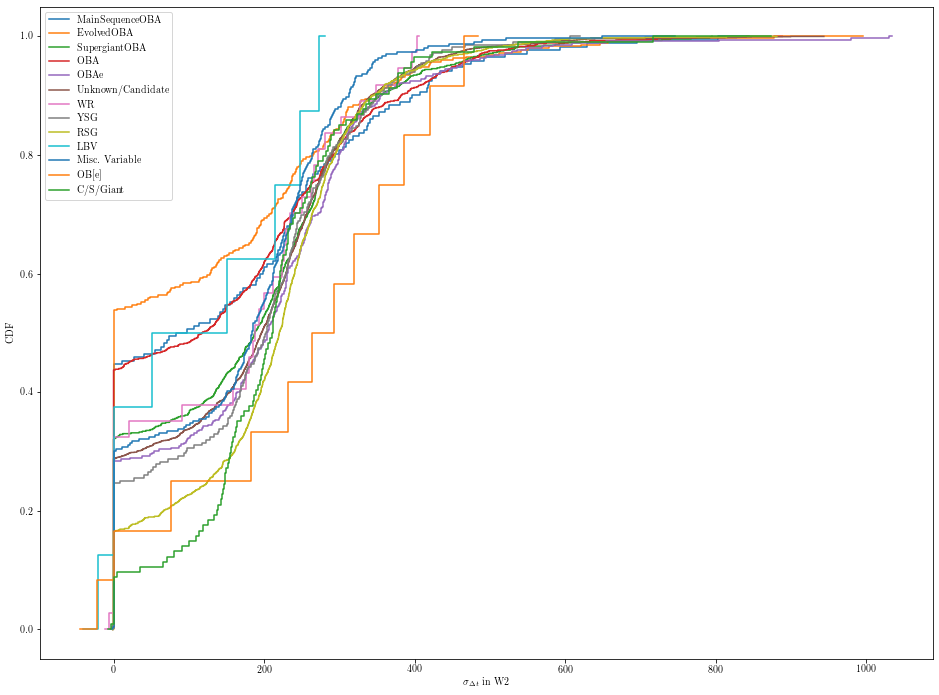

In [26]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W2_stdDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlabel(r'$\sigma_{\Delta t}$ in W2')
plt.ylabel('CDF')

Text(0, 0.5, 'CDF')

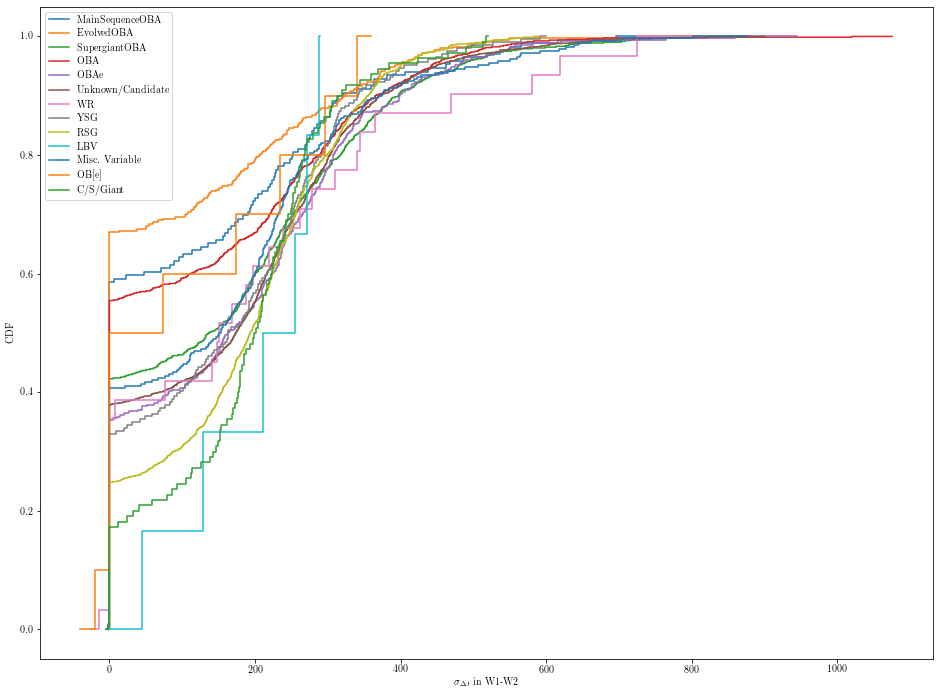

In [27]:
fig = plt.figure(figsize=(16,12))
for i,cl in enumerate(joined['Class'].unique()):
    vals, density = cdf(joined['W1-W2_stdDt'][joined['Class']==cl].values)
    plt.step(vals,density,where='mid',label=cl)
plt.legend()
plt.xlabel(r'$\sigma_{\Delta t}$ in W1-W2')
plt.ylabel('CDF')